[베이스라인 코드](https://dacon.io/competitions/official/236336/codeshare) 참고

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 31.5 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
import os
import random
from math import log10, sqrt

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, rdkit.Chem.rdDepictor, rdkit.Chem.Draw

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [4]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

In [6]:
my_elements = {
    1: 'H', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 11: 'Na', 12: 'Mg',
    13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 19: 'K', 20: 'Ca', 26: 'Fe', 29: 'Cu',
    35: 'Br', 53: 'I'
}

# Dataset: ChEMBL & Smiles

### DataLoad

In [7]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [8]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('/content/drive/MyDrive/dacon/preprocessed_train.csv')
chembl_data.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL210822,IC50,'=',2000.0,nM,5.70,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,2000.0,5.70,CCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21
1,CHEMBL3908695,IC50,'=',5.6,nM,8.25,CHEMBL3887118,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886172,5.6,8.25,CC(C)Nc1cc(-n2ccc3cc(C#N)cnc32)ncc1C(=O)NCCCOC...
2,CHEMBL5277222,IC50,'=',32.0,nM,7.50,CHEMBL5246637,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL5244269,32.0,7.50,CC(=O)N1CCC(n2cc(Nc3nc(OC4CCOCC4)c4nc(CC#N)ccc...
3,CHEMBL4518357,IC50,'=',190.0,nM,6.72,CHEMBL4427852,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4425185,190.0,6.72,CN(C)[C@H]1CN(C(=O)c2nn(C)cc2NC(=O)c2cccc(-c3c...
4,CHEMBL3947682,IC50,'=',5.5,nM,8.26,CHEMBL3887118,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3886172,5.5,8.26,CC(C)Nc1cc(-n2ccc3cc(C#N)cnc32)ncc1C(=O)NCCCOC...


In [9]:
num_chembl = len(chembl_data['Assay ChEMBL ID'].unique())
num_smiles = len(chembl_data['Smiles'].unique())

print('Number of Assay ChEMBL IDs', num_chembl)
print('Number of Smiles', num_smiles)

Number of Assay ChEMBL IDs 72
Number of Smiles 1840


### Data Pre-processing

In [10]:
def example():
    for i in range(len(chembl_data)):
        graph = gen_smiles2graph(chembl_data.Smiles[i])
        pic = chembl_data.pIC50[i]
        yield graph, pic


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, len(my_elements)]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [11]:
val_data = data.take(390)
train_data = data.skip(390)

# GCN Implementation

In [12]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)

        return out, adj

In [13]:
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        # compute the mean over the nodes
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [14]:
ninput = tf.keras.Input(
    (
        None,
        len(my_elements),
    )
)

ainput = tf.keras.Input(
    (
        None,
        None,
    )
)

# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)

# reduce to graph features
x = GRLayer()(x)

# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 21)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None, None)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gcn_layer (GCNLayer)      │ [(None, None, 21),     │            441 │ input_layer[0][0],     │
│                           │ (None, None, None)]    │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gcn_layer_1 (GCNLayer)    │ [(None, None, 21),     │            441 │ gcn_layer[0][0],       │
│                           │ (None, None, None)]    │                │ gcn_layer[0][1]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gcn_layer_2 (GCNLayer)    │ [(None, None, 21),     │            441 │ gcn_layer_1[0][0],     │
│                           │ (None, None, None)]    │                │ gcn_layer_1[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gcn_layer_3 (GCNLayer)    │ [(None, None, 21),     │            441 │ gcn_layer_2[0][0],     │
│                           │ (None, None, None)]    │                │ gcn_layer_2[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GRLayer (GRLayer)         │ (None, 21)             │              0 │ gcn_layer_3[0][0],     │
│                           │                        │                │ gcn_layer_3[0][1]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │            352 │ GRLayer[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             17 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,133 (8.33 KB)

 Trainable params: 2,133 (8.33 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['accuracy'])
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=10)

Epoch 1/10
   1444/Unknown 21s 11ms/step - accuracy: 0.0000e+00 - loss: 9.9308

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1450/1450 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.0000e+00 - loss: 9.8990 - val_accuracy: 0.0000e+00 - val_loss: 1.1933
Epoch 2/10
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.0000e+00 - loss: 1.3123 - val_accuracy: 0.0000e+00 - val_loss: 1.1908
Epoch 3/10
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0000e+00 - loss: 1.3089 - val_accuracy: 0.0000e+00 - val_loss: 1.1422
Epoch 4/10
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.0000e+00 - loss: 1.1873 - val_accuracy: 0.0000e+00 - val_loss: 0.8520
Epoch 5/10
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0000e+00 - loss: 0.9932 - val_accuracy: 0.0000e+00 - val_loss: 0.8175
Epoch 6/10
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0000e+00 - loss: 0.9608 - val_accuracy: 0.0000e+00 - val_loss: 0.8094
Epoch 7/10
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.0000e+00 - loss: 0.9423 - val_accuracy: 0.0000e+00 - val_loss: 0.8105
Epoch 8/10
1450/1450 ━━━━━━━━━━━━━━━

Best Train Accuracy: 0.0000 (1 epochs)
Best Validation Accuracy: 0.0000 (1 epochs)


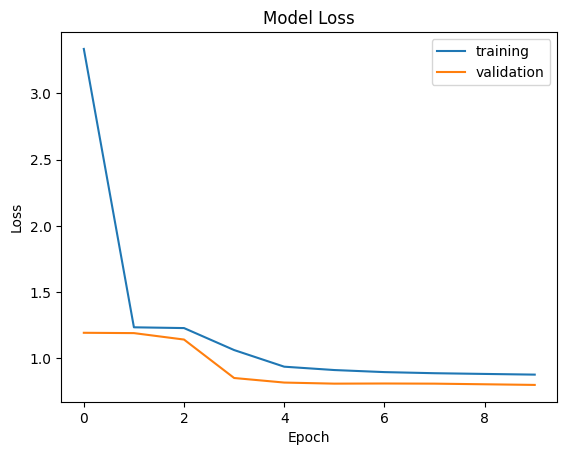

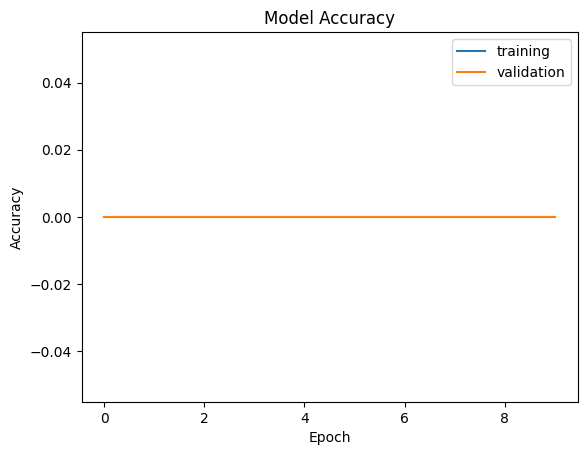

In [17]:
best_train = max(result.history['accuracy'])
best_val = max(result.history['val_accuracy'])

train_epoch = result.history['accuracy'].index(best_train) + 1
val_epoch = result.history['val_accuracy'].index(best_val) + 1

print(f"Best Train Accuracy: {best_train:.4f} ({train_epoch} epochs)")
print(f"Best Validation Accuracy: {best_val:.4f} ({val_epoch} epochs)")

# loss
plt.plot(result.history['loss'], label="training")
plt.plot(result.history['val_loss'], label="validation")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(result.history['accuracy'], label="training")
plt.plot(result.history['val_accuracy'], label="validation")
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation

In [18]:
def pIC50_to_IC50(pic50_values):
    return 10 ** (9 - pic50_values)

In [22]:
test = pd.read_csv('/content/drive/MyDrive/dacon/preprocessed_test.csv')

In [23]:
def test_example():
    for i in range(len(test)):
        graph = gen_smiles2graph(test.Smiles[i])
        pic = test.pIC50[i]
        yield graph, pic


test_data = tf.data.Dataset.from_generator(
    test_example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, len(my_elements)]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

In [27]:
y_pred = model.predict(test_data.batch(1), verbose=0)[:, 0]
y_true = test.pIC50

y_pred, y_true = pIC50_to_IC50(y_pred), pIC50_to_IC50(y_true)

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [31]:
# RMSE 계산
rmse = sqrt(mean_squared_error(y_true, y_pred))

# Normalized RMSE 계산
normalized_rmse = rmse / (np.max(y_true) - np.min(y_pred))

# Absolute Error for IC50_nm
absolute_error = np.abs(y_true - y_pred)

# Correct Ratio 계산 (절대 오차가 0.5 이하인 비율)
correct_ratio = np.mean(absolute_error <= 0.5)

# 종합 점수 계산
score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

print(f"Normalized RMSE (A): {normalized_rmse}")
print(f"Correct Ratio (B): {correct_ratio}")
print(f"Score: {score}")

Normalized RMSE (A): 0.11254786500427097
Correct Ratio (B): 0.008928571428571428
Score: 0.4481903532121502


# Submission

In [32]:
submit_test = pd.read_csv('/content/drive/MyDrive/dacon/test.csv')

def submit_example():
    for i in range(len(submit_test)):
        graph = gen_smiles2graph(submit_test.Smiles[i])
        pic = None
        yield graph, pic


submit_data = tf.data.Dataset.from_generator(
    submit_example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, len(my_elements)]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

y_pred = model.predict(submit_data.batch(1), verbose=0)[:, 0]

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### Submission

In [33]:
submit = pd.read_csv('/content/drive/MyDrive/dacon/sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,34.838116
1,TEST_001,26.396624
2,TEST_002,26.453228
3,TEST_003,34.554955
4,TEST_004,31.006531


In [34]:
submit.to_csv('/content/drive/MyDrive/dacon/submit_v1.csv', index=False)